In [60]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [62]:
class TerminateOnBaseline(keras.callbacks.Callback):
    """Callback that terminates training when val_loss reaches a specified baseline
    """

    def __init__(self, monitor='val_loss', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get(self.monitor)
        if val_loss is not None:
            if val_loss < self.baseline:
                print(f'\n\nEpoch {epoch}: Reached baseline, terminating training\n\n')
                self.model.stop_training = True
  

class LossHistory(keras.callbacks.Callback):
    def __init__(self, x_test, y_test, res):
        super().__init__()
        self.test_losses = None
        self.x_test = x_test
        self.y_test = y_test
        self.res = res

    def on_train_begin(self, logs=None):
        self.test_losses = list()

    def on_epoch_begin(self, epoch, logs=None):
        if logs is None:
            logs = {}
        predicted = self.model.predict(np.stack([self.x_test, self.y_test], axis=1))
        scce = tf.keras.losses.SparseCategoricalCrossentropy()
        self.test_losses.append(scce(self.res, predicted).numpy())

class AccHistory(keras.callbacks.Callback):
    def __init__(self, x_test, y_test, res):
        super().__init__()
        self.test_acc = None
        self.x_test = x_test
        self.y_test = y_test
        self.res = res

    def on_train_begin(self, logs=None):
        self.test_acc = list()

    def on_epoch_begin(self, epoch, logs=None):
        if logs is None:
            logs = {}
        predicted_ = self.model.predict(np.stack([self.x_test, self.y_test], axis=1))
        predicted = np.zeros(len(predicted_))
        predicted = [np.argmax(p) for p in predicted_]
        m = tf.keras.metrics.Accuracy()
        m.update_state(self.res, predicted)
        self.test_acc.append(m.result().numpy())

Загрузка данных

In [63]:
df = pd.read_csv('sample_data/data_lab3v02.csv', names=['x', 'y', 'res']).sample(frac=1).reset_index(drop=True)
df.res = ((df.res + 1) / 2).astype(int)
df_pos = df[df.res == 1].drop(columns=['res']).reset_index(drop=True)
df_neg = df[df.res == 0].drop(columns=['res']).reset_index(drop=True)
df_train = df[:210].reset_index(drop=True)
df_valid = df[210:315].reset_index(drop=True)
df_test = df[315:].reset_index(drop=True)

count_ones = (df_train['res'] == 1).sum()
print("Number of 1's in df_train:", count_ones)
count_ones = (df_valid['res'] == 1).sum()
print("Number of 1's in df_valid:", count_ones)
count_ones = (df_test['res'] == 1).sum()
print("Number of 1's in df_test:", count_ones)
df

Number of 1's in df_train: 91
Number of 1's in df_valid: 40
Number of 1's in df_test: 19


,x,y,res
0,3.35780,2.61760,0
1,1.67710,1.24690,0
2,3.13130,5.38450,1
3,2.46080,0.54395,0
4,0.35098,1.15100,0
...,...,...,...
345,1.85310,-0.91229,0
346,3.78950,3.14080,0
347,7.20220,3.18360,1
348,1.21220,0.78975,0


Диаграма рассеяния

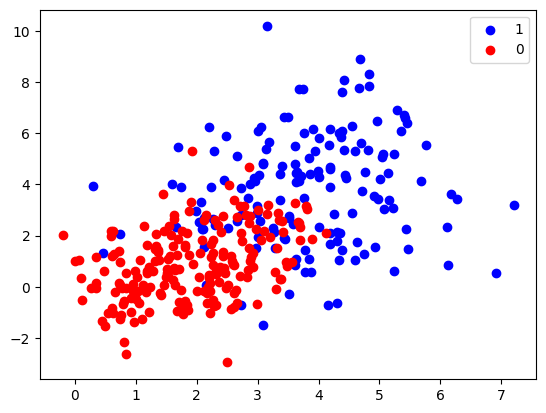

In [64]:
plt.scatter(df_pos.x, df_pos.y, color='b', label="1")
plt.scatter(df_neg.x, df_neg.y, color='r', label="0")
plt.legend()
plt.show()

создание модели

In [65]:
n1 = 20
n2 = 20
learning_rate = 0.01
momentum = 0.80

model = keras.Sequential()
model.add(keras.layers.Dense(n1, use_bias=True, activation=keras.activations.sigmoid, kernel_initializer="glorot_uniform", bias_initializer='zeros'))
model.add(keras.layers.Dense(n2, use_bias=True, activation=keras.activations.sigmoid, kernel_initializer="glorot_uniform", bias_initializer='zeros'))
model.add(keras.layers.Dense(2, use_bias=True, activation=keras.activations.linear, kernel_initializer="glorot_uniform", bias_initializer='zeros'))
model.add(keras.layers.Softmax())
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

callb = LossHistory(df_test.x.to_numpy(), df_test.y.to_numpy(), df_test.res.to_numpy())
callb2 = AccHistory(df_test.x.to_numpy(), df_test.y.to_numpy(), df_test.res.to_numpy())
callbacks = [callb, callb2]

Обучение

In [66]:
train = np.stack([df_train.x.to_numpy(), df_train.y.to_numpy()], axis=1)
valid = np.stack([df_valid.x.to_numpy(), df_valid.y.to_numpy()], axis=1)
test = np.stack([df_test.x.to_numpy(), df_test.y.to_numpy()], axis=1)
train_res = df_train.res.to_numpy()
valid_res = df_valid.res.to_numpy()
test_res = df_test.res.to_numpy()

history = model.fit(train, train_res, epochs=100, validation_data=(valid, valid_res), callbacks=callbacks, batch_size=1)
score = model.evaluate(test, test_res)

2/2 [==============================] - 0s 6ms/step
Epoch 1/100
2/2 [==============================] - 0s 5ms/step
Epoch 2/100
2/2 [==============================] - 0s 6ms/step
Epoch 3/100
2/2 [==============================] - 0s 6ms/step
Epoch 4/100
2/2 [==============================] - 0s 8ms/step
Epoch 5/100
2/2 [==============================] - 0s 4ms/step
Epoch 6/100
2/2 [==============================] - 0s 6ms/step
Epoch 7/100
2/2 [==============================] - 0s 4ms/step
Epoch 8/100
2/2 [==============================] - 0s 9ms/step
Epoch 9/100
2/2 [==============================] - 0s 6ms/step
Epoch 10/100
2/2 [==============================] - 0s 4ms/step
Epoch 11/100
2/2 [==============================] - 0s 7ms/step
Epoch 12/100
2/2 [==============================] - 0s 6ms/step
Epoch 13/100
2/2 [==============================] - 0s 4ms/step
Epoch 14/100
2/2 [==============================] - 0s 7ms/step
Epoch 15/100
2/2 [==============================] - 0s 6ms/ste

In [67]:
print(train)

[[ 3.3578e+00  2.6176e+00]
 [ 1.6771e+00  1.2469e+00]
 [ 3.1313e+00  5.3845e+00]
 [ 2.4608e+00  5.4395e-01]
 [ 3.5098e-01  1.1510e+00]
 [ 2.6083e+00  8.5400e-01]
 [ 1.7349e+00  3.8812e+00]
 [ 3.8849e+00  1.8703e+00]
 [ 4.4215e+00  8.0763e+00]
 [ 2.1487e+00  2.8125e+00]
 [ 1.2241e+00 -9.8226e-01]
 [ 7.3112e-01  1.3975e+00]
 [ 1.0181e+00  3.7277e-01]
 [ 3.5766e+00  2.4699e+00]
 [ 3.1768e+00  3.1809e+00]
 [ 4.6894e+00  5.6310e+00]
 [ 3.6307e+00  1.0677e+00]
 [ 1.3072e+00  1.0021e+00]
 [ 1.9173e+00  5.3197e+00]
 [ 2.6184e+00  3.4031e+00]
 [ 2.2203e+00 -1.0420e+00]
 [ 2.6638e+00 -6.2919e-01]
 [ 7.4036e-01  2.0651e+00]
 [ 2.5080e+00  2.2807e+00]
 [ 2.5647e+00  1.2034e+00]
 [ 9.5549e-01  9.5830e-02]
 [ 4.7696e+00  4.4728e+00]
 [ 3.5251e-01 -4.2357e-02]
 [ 2.1830e+00 -1.4540e-02]
 [ 1.3313e+00  2.0734e+00]
 [ 3.6233e+00  4.0864e+00]
 [ 5.9290e-01  2.1695e+00]
 [ 3.1077e+00  2.1808e+00]
 [ 3.7830e+00  1.4363e+00]
 [ 3.3600e+00  3.3882e+00]
 [ 4.3062e+00  1.8029e+00]
 [ 4.4198e+00  5.3330e+00]
 

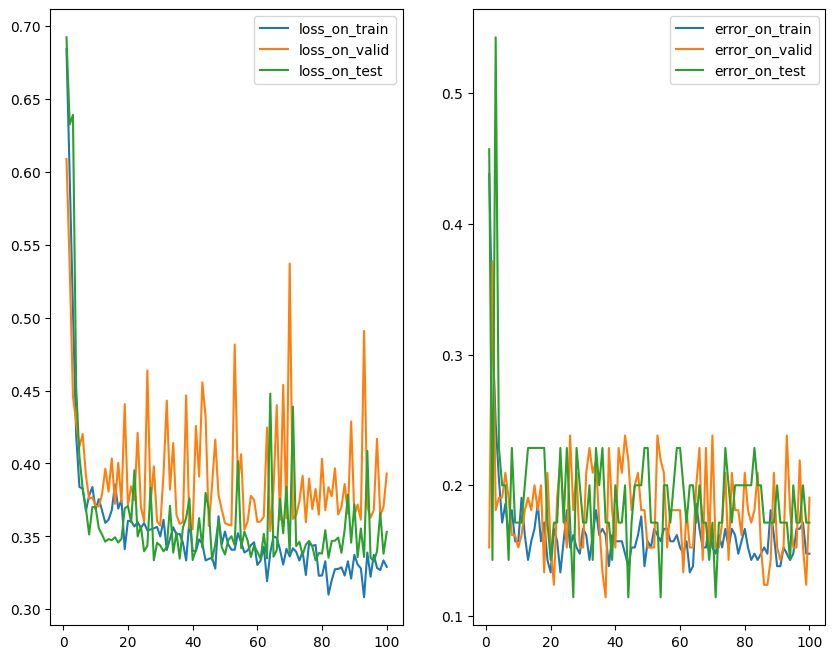

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
l = len(history.history['loss'])
epochs = np.linspace(1, l, l)

ax[0].plot(epochs, history.history['loss'], label='loss_on_train')
ax[0].plot(epochs, history.history['val_loss'], label='loss_on_valid')
ax[0].plot(epochs, callb.test_losses, label='loss_on_test')

ax[1].plot(epochs, [1 - x for x in history.history['accuracy']], label='error_on_train')
ax[1].plot(epochs, [1 - x for x in history.history['val_accuracy']], label='error_on_valid')
ax[1].plot(epochs, [1 - x for x in callb2.test_acc], label='error_on_test')

for j in range (2):
  ax[j].legend()
plt.show()

32/32 [==============================] - 0s 1ms/step


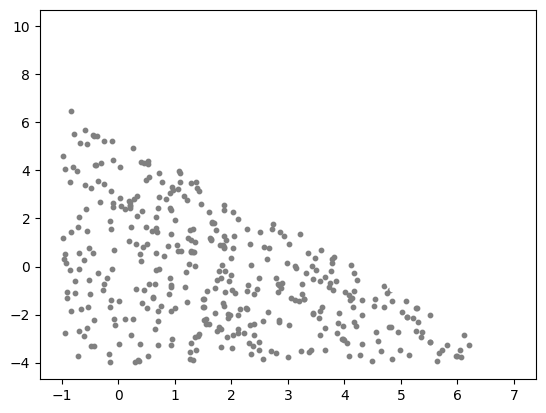

In [69]:
x = np.random.uniform(-1, 7, size=1000)
y = np.random.uniform(-4, 10, size=1000)

res_ = model.predict(np.stack([x,y], axis=1))
res = [np.argmax(r) for r in res_]

for i, (x,y) in enumerate(zip(x,y)):
  if res[i] == 0:
    plt.scatter(x, y, color='gray', s=10)
  else:
    plt.scatter(x, y, color='white', s=10)

plt.show()

In [70]:
print(model.evaluate(train, train_res))
print(model.evaluate(valid, valid_res))
print(model.evaluate(test, test_res))

7/7 [==============================] - 0s 2ms/step - loss: 0.3089 - accuracy: 0.8714
[0.30889031291007996, 0.8714285492897034]
4/4 [==============================] - 0s 4ms/step - loss: 0.3931 - accuracy: 0.8095
[0.3931290805339813, 0.8095238208770752]
2/2 [==============================] - 0s 6ms/step - loss: 0.3512 - accuracy: 0.8000
[0.3512377142906189, 0.800000011920929]


In [71]:
class _model_():
    def __init__(self, model):
        self.model = model
    def predict(self, v):
        return np.array([np.argmax(k) for k in self.model.predict(v)])

2/2 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'test')

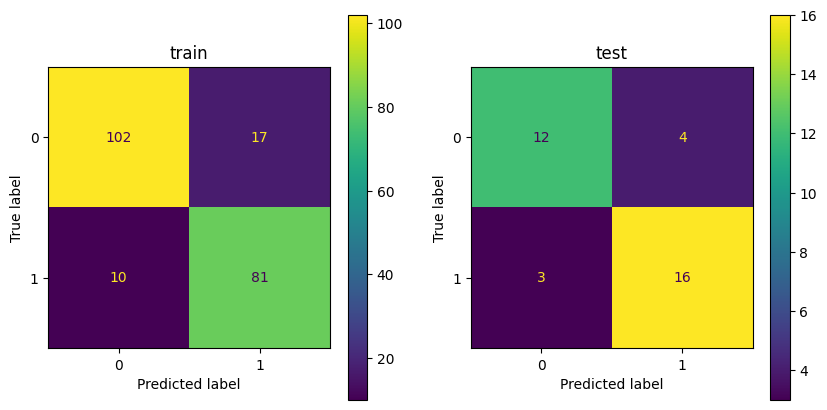

In [72]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
train = np.stack([df_train.x.to_numpy(), df_train.y.to_numpy()], axis=1)
test = np.stack([df_test.x.to_numpy(), df_test.y.to_numpy()], axis=1)
train_res = df_train.res.to_numpy()
test_res = df_test.res.to_numpy()

m = _model_(model)

conf_matrix = confusion_matrix(train_res, m.predict(train))
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot(ax=ax[0])
ax[0].set_title('train');

conf_matrix = confusion_matrix(test_res, m.predict(test))
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot(ax=ax[1])
ax[1].set_title('test')

2813/2813 [==============================] - 4s 1ms/step


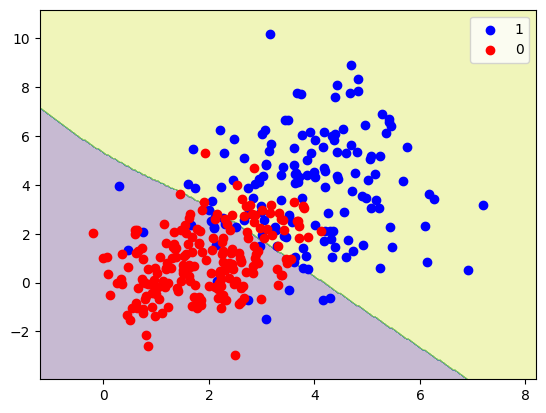

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x_range = np.linspace(df['x'].min()-1, df['x'].max()+1, 300)
y_range = np.linspace(df['y'].min()-1, df['y'].max()+1, 300)
grid_x, grid_y = np.meshgrid(x_range, y_range)

xy_grid = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)

pred_grid = model.predict(xy_grid)
class_grid = np.argmax(pred_grid, axis=1)

class_grid = class_grid.reshape(grid_x.shape)

plt.contourf(grid_x, grid_y, class_grid, alpha=0.3)

df_pos = df[df.res == 1]
df_neg = df[df.res == 0]

plt.scatter(df_pos.x, df_pos.y, color='b', label="1")
plt.scatter(df_neg.x, df_neg.y, color='r', label="0")
plt.legend()
plt.show()